# Fitting Multivariate Distributions

*Purpose*: 


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

For this exercise, we'll study a dataset of observations on die cast aluminum parts.


In [2]:
from grama.data import df_shewhart


# Dependency in the wild


TODO

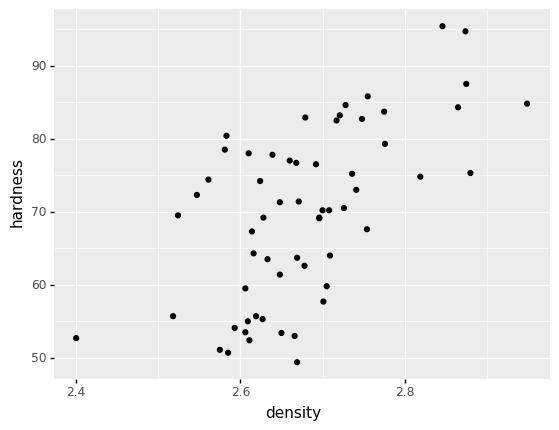

<ggplot: (8786955922270)>

In [3]:
(
    df_shewhart
    >> gr.ggplot(gr.aes("density", "hardness"))
    + gr.geom_point()
)

A normal distribution does a *reasonable* job representing both `density` and `hardness`.


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


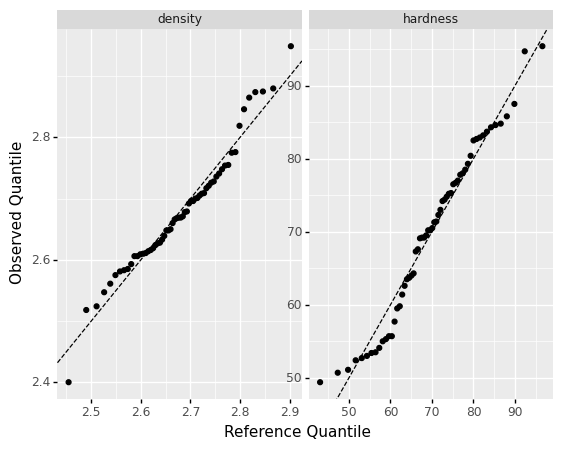

<ggplot: (8786956154405)>

In [4]:
## NOTE: No need to edit
(
    df_shewhart
    >> gr.tf_mutate(
        q_density=gr.qqvals(DF.density, "norm"),
        q_hardness=gr.qqvals(DF.hardness, "norm"),
    )
    >> gr.tf_rename(
        v_density="density",
        v_hardness="hardness",
    )
    >> gr.tf_pivot_longer(
        columns=["q_density", "q_hardness", "v_density", "v_hardness"],
        names_to=[".value", "var"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("q", "v"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.facet_wrap("var", scales="free")
    + gr.labs(x="Reference Quantile", y="Observed Quantile")
)

However,


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


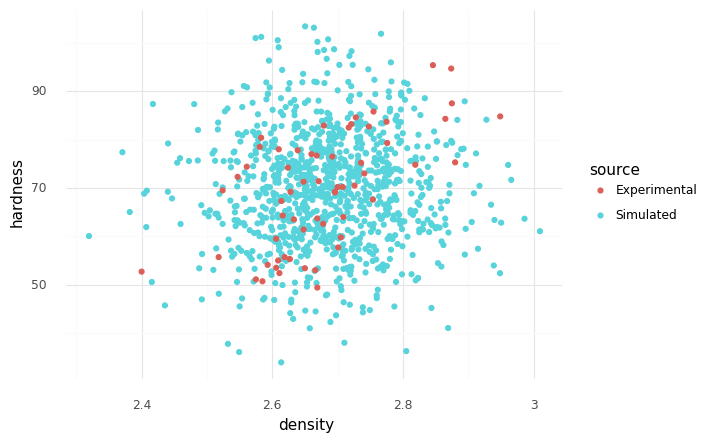

<ggplot: (8786956164660)>

In [5]:
## NOTE: No need to edit
# Build a model 
md_independence = (
    gr.Model("Independent Properties")
    >> gr.cp_marginals(
        density=gr.marg_fit("norm", df_shewhart.density),
        hardness=gr.marg_fit("norm", df_shewhart.hardness),
    )
    >> gr.cp_copula_independence()
)

# Draw simulated observations
(
    md_independence
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulated")
    >> gr.tf_bind_rows(
        df_shewhart
        >> gr.tf_mutate(source="Experimental")
    )
    
    >> gr.ggplot(gr.aes("density", "hardness"))
    + gr.geom_point(gr.aes(color="source"))
    + gr.theme_minimal()
)

This model does not respect the correlation we observe in the data.


# Marginal-Copula Approach


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


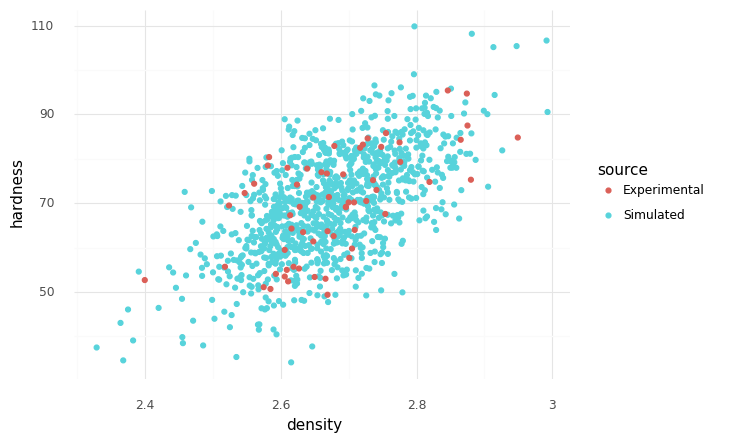

<ggplot: (8786955798459)>

In [6]:
## NOTE: No need to edit
# Build a model 
md_copula = (
    gr.Model("Independent Properties")
    >> gr.cp_marginals(
        density=gr.marg_fit("norm", df_shewhart.density),
        hardness=gr.marg_fit("norm", df_shewhart.hardness),
    )
    ## KEY DIFFERENCE: Fit a gaussian copula
    >> gr.cp_copula_gaussian(df_data=df_shewhart)
)

# Draw simulated observations
(
    md_copula
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.tf_mutate(source="Simulated")
    >> gr.tf_bind_rows(
        df_shewhart
        >> gr.tf_mutate(source="Experimental")
    )
    
    >> gr.ggplot(gr.aes("density", "hardness"))
    + gr.geom_point(gr.aes(color="source"))
    + gr.theme_minimal()
)

## Steps

1. Fit a marginal for each uncertain quantity
    - Follow the process from `e-grama06-fit-univar`; this should include checking for statistical control!
2. Fit a copula to relate the uncertain quantities
3. Assess the model


# Case Study: Circuit Performance


In [7]:
from grama.models import make_prlc_rand
md_circuit = make_prlc_rand()
md_circuit

model: RLC with component tolerances

  inputs:
    var_det:
      C: [0.001, 100]
      R: [0.001, 1.0]
      L: [1e-09, 0.001]

    var_rand:
      dR: (+0) uniform, {'mean': '0.000e+00', 's.d.': '3.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dL: (+0) uniform, {'mean': '0.000e+00', 's.d.': '6.000e-02', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}
      dC: (+0) uniform, {'mean': '3.000e-01', 's.d.': '2.900e-01', 'COV': 0.96, 'skew.': 0.0, 'kurt.': 1.8}

    copula:
      Independence copula

  functions:
      f0: ['R', 'dR', 'L', 'dL', 'C', 'dC'] -> ['Rr', 'Lr', 'Cr']
      f1: ['Lr', 'Cr'] -> ['omega0']
      parallel RLC: ['omega0', 'Rr', 'Cr'] -> ['Q']

eval_sample() is rounding n...


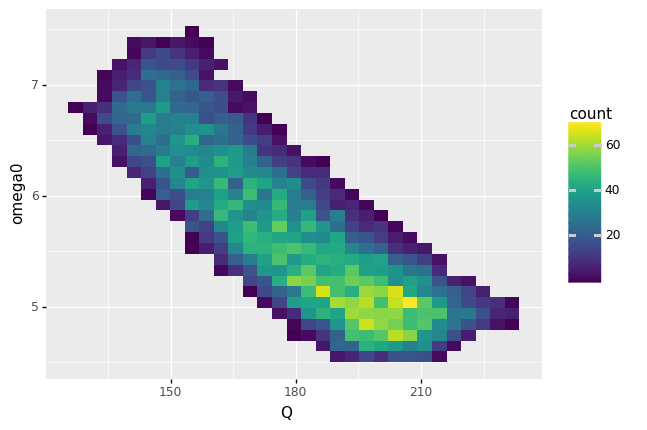

<ggplot: (8786955615181)>

In [8]:
df_circuit = (
    md_circuit
    >> gr.ev_sample(n=1e4, df_det="nom", seed=101)
)

(
    df_circuit
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
)

## Marginals


### __qX__ Check for statistical control

Check for statistical control of the output `omega0`. Use a control chart to make this determination.

*Hint*: You *do not* need to write all this code from scratch! Try copying code from the previous exercise `e-grama-06-fit-univar`.


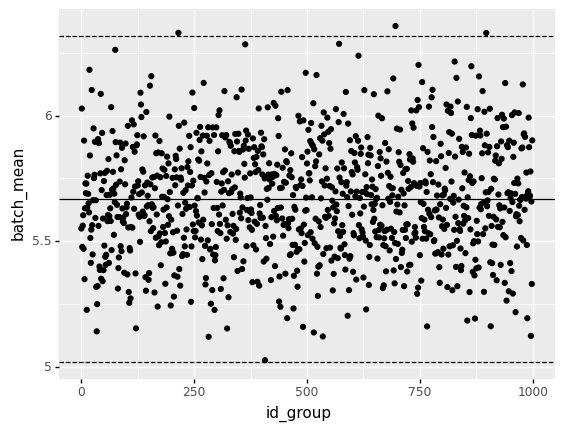

<ggplot: (8786955416348)>

In [9]:
## TASK: Make a control chart of batch size n_batch = 10
# solution-begin
n_batch = 10

df_stats = (
    df_circuit
    >> gr.tf_summarize(
        omega0_mean=gr.mean(DF.omega0),
        omega0_sd=gr.sd(DF.omega0),
    )
    >> gr.tf_mutate(
        omega0_lo=DF.omega0_mean - 3 * DF.omega0_sd / gr.sqrt(n_batch),
        omega0_up=DF.omega0_mean + 3 * DF.omega0_sd / gr.sqrt(n_batch),
    )
)

(
    df_circuit
    >> gr.tf_mutate(id_group=DF.index // n_batch)
    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(batch_mean=gr.mean(DF.omega0))
    
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        df_stats,
        gr.aes(yintercept="omega0_lo"),
        linetype="dashed",
    )
    + gr.geom_hline(
        df_stats,
        gr.aes(yintercept="omega0_up"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_stats,
        mapping=gr.aes(yintercept="omega0_mean"),
    )
    + gr.geom_point()
)
# solution-end

*Observations*

<!-- task-begin -->
- How many batches *total* are there?
  - (Your response here)
- How many batches fall outside the control limits? Is that significantly more than we would expect?
  - (Your response here)
- Does this process seem to be under statistical control?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How many batches *total* are there?
  - With a batch size of `n_batch = 10` there are `1000` batches.
- How many batches fall outside the control limits? Is that significantly more than we would expect?
  - I see three batches outside the control limits (though this will vary---the code output is random). This is not significantly more than the ~1 per thousand batches we would expect to exceed the limits.
- Does this process seem to be under statistical control?
  - Yes; there are not too many outlier batches, and there are no other suspicious patterns.
<!-- solution-end -->


### __qX__ Fit a marginal for `omega0`


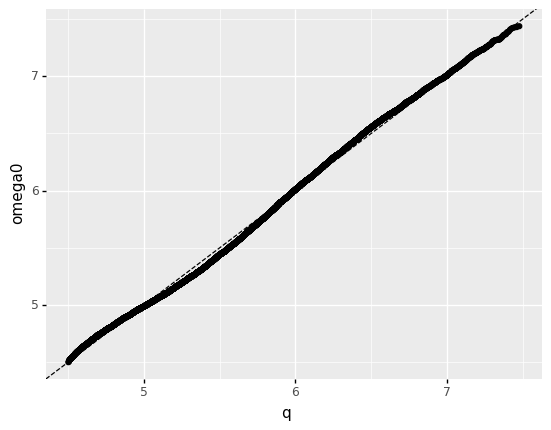

<ggplot: (8786955399647)>

In [10]:
## TASK: Fit a marginal for `omega0`
# task-begin
mg_omega0 = None
# task-end
# solution-begin
mg_omega0 = gr.marg_fit("beta", df_circuit.omega0)
# solution-end

## NOTE: Use the following to help check your work
(
    df_circuit
    >> gr.tf_mutate(q=gr.qqvals(DF.omega0, marg=mg_omega0))
    >> gr.ggplot(gr.aes("q", "omega0"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
)

*Observations*

<!-- task-begin -->
- How well does your distribution fit the data?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How well does your distribution fit the data?
  - Quite well! There is some inaccuracy in the left tail, but overall it agrees nicely.
<!-- solution-end -->


### __qX__ Fit a marginal for `Q`


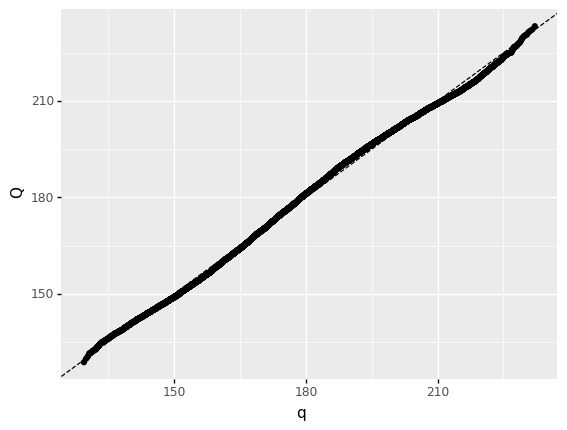

<ggplot: (8786955491154)>

In [11]:
## TASK: Fit a marginal for `Q`
# task-begin
mg_Q = None
# task-end
# solution-begin
mg_Q = gr.marg_fit("beta", df_circuit.Q)
# solution-end

## HINT: Use the assessment techniques discussed in 
# the previous exercise
# solution-begin
(
    df_circuit
    >> gr.tf_mutate(q=gr.qqvals(DF.Q, marg=mg_Q))
    >> gr.ggplot(gr.aes("q", "Q"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
)
# solution-end

*Observations*

<!-- task-begin -->
- How well does your distribution fit the data?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How well does your distribution fit the data?
  - Quite well! There is some wavering throughout, but the overall shape is correct.
<!-- solution-end -->


## Copula


In [12]:
## NOTE: No need to edit
md_out_independence = (
    gr.Model("Circuit Output: Independence")
    >> gr.cp_marginals(
        omega0=mg_omega0,
        Q=mg_Q,
    )
    >> gr.cp_copula_independence()
)

md_out_independence 


model: Circuit Output: Independence

  inputs:
    var_det:

    var_rand:
      omega0: (+0) beta, {'mean': '5.680e+00', 's.d.': '6.700e-01', 'COV': 0.12, 'skew.': 0.34, 'kurt.': 2.27}
      Q: (+0) beta, {'mean': '1.793e+02', 's.d.': '2.142e+01', 'COV': 0.12, 'skew.': 0.05, 'kurt.': 2.25}

    copula:
      Independence copula

  functions:

### __qX__ Fit a gaussian copula

*Hint*: The code above demonstrates how to add a gaussian copula to a grama model.


In [13]:
## TASK: Fit a gaussian copula model
md_out_copula = (
    gr.Model("Circuit Output: Copula")
    >> gr.cp_marginals(
        omega0=mg_omega0,
        Q=mg_Q,
    )
# solution-begin
    >> gr.cp_copula_gaussian(df_data=df_circuit)
# solution-end
)

## NOTE: Do not edit; use this to check your work
assert \
    isinstance(md_out_copula.density.copula, gr.CopulaGaussian), \
    "md_out_copula must have a gaussian copula"

md_out_copula 


model: Circuit Output: Copula

  inputs:
    var_det:

    var_rand:
      omega0: (+0) beta, {'mean': '5.680e+00', 's.d.': '6.700e-01', 'COV': 0.12, 'skew.': 0.34, 'kurt.': 2.27}
      Q: (+0) beta, {'mean': '1.793e+02', 's.d.': '2.142e+01', 'COV': 0.12, 'skew.': 0.05, 'kurt.': 2.25}

    copula:
      Gaussian copula with correlations:
     var1 var2      corr
0  omega0    Q -0.817849

  functions:

### __qX__ Compare the models

Use the following code to compare the multivariate models; answer the questions under *observations* below.


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.


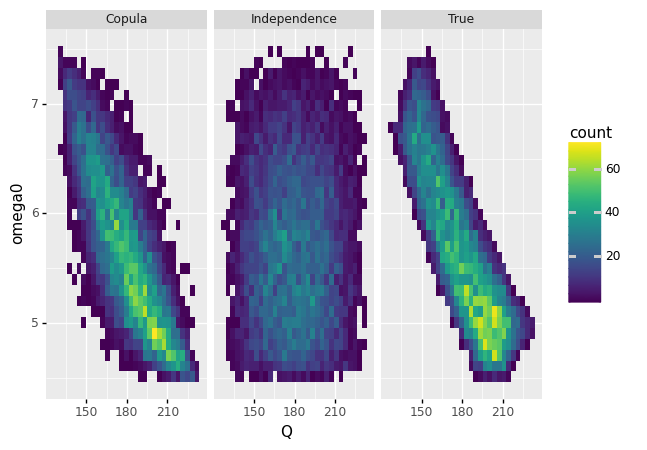

<ggplot: (8786955743031)>

In [14]:
## NOTE: No need to edit
(
    df_circuit
    >> gr.tf_mutate(source="True")
    >> gr.tf_bind_rows(
        md_out_independence
        >> gr.ev_sample(n=1e4, df_det="nom", skip=True)
        >> gr.tf_mutate(source="Independence")
    )
    >> gr.tf_bind_rows(
        md_out_copula
        >> gr.ev_sample(n=1e4, df_det="nom", skip=True)
        >> gr.tf_mutate(source="Copula")
    )
    
    >> gr.ggplot(gr.aes("Q", "omega0"))
    + gr.geom_bin2d()
    + gr.facet_wrap("source")
)

*Observations*

<!-- task-begin -->
- How well does the independence model represent the true data?
  - (Your response here)
- What aspects does the copula model get *correct*?
  - (Your response here)
- What aspects does the copula model get *incorrect*?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How well does the independence model represent the true data?
  - Abysmal! The independence model does a terrible job representing the true data. For instance, the independence model does not capture the concentration of values at high `Q` and low `omega0`.
- What aspects does the copula model get *correct*?
  - The copula model gets the rough correlation correct, and correctly concentrates towards high `Q` and low `omega0`.
- What aspects does the copula model get *incorrect*?
  - The copula model "bows" along the edges, whereas the true data has a very "sharp" edge to the observations, almost like a bar.
<!-- solution-end -->